# Pop vs Non-Pop Genre Classification
**by Kyle Furey & Dhruv Solanki**


## 1. Setup & Data Loading


In [14]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfl
from tensorflow.keras import callbacks as tfkc



In [15]:
# Load behavioral Spotify dataset - CLEANED VERSION (No Data Leakage)
DATA_PATH = '../data/spotify_final_with_behavior.csv'

print('Loading data from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
print('Total samples:', len(df))

# Define pop-vs-non-pop label using tags/genre (real Spotify metadata)
import re

pop_keyword_patterns = [
    r"\bpop\b",
    r"dance[- ]?pop",
    r"electro[- ]?pop",
    r"synth[- ]?pop",
    r"teen pop",
    r"pop rock",
    r"pop rap",
    r"latin pop",
    r"indie pop",
    r"k[- ]?pop",
    r"j[- ]?pop",
    r"c[- ]?pop",
]

def is_pop_track(row):
    # Genre column now contains the actual genres (was moved from tags column)
    text = f"{row.get('genre', '')}".lower()
    return int(any(re.search(pat, text) for pat in pop_keyword_patterns))

df['is_pop_genre'] = df.apply(is_pop_track, axis=1)
print('Pop class positive rate:', df['is_pop_genre'].mean())
print(f'Pop tracks: {df["is_pop_genre"].sum()}, Non-pop: {(df["is_pop_genre"] == 0).sum()}')

# ============================================================================
# FEATURE SELECTION - REMOVING DATA LEAKAGE
# ============================================================================
# CRITICAL: Remove features that are engineered to predict pop (data leakage)
# These features are too correlated with the target and give unrealistic results

# Base numeric features (safe - no leakage)
numeric_features = ['spotify_popularity', 'album_release_year', 'tempo_bpm_synth', 'position']
cat_feature = 'time_of_day_synth'
target_column = 'is_pop_genre'

# Extract additional safe features
df['is_explicit_binary'] = df['is_explicit'].astype(int)

# Extract temporal features from album_release_date
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')
df['release_month'] = df['album_release_date'].dt.month.fillna(0).astype(int)
df['release_decade'] = (df['album_release_year'] // 10 * 10).astype(int)

# Create interaction features (safe - no direct pop targeting)
df['popularity_x_year'] = df['spotify_popularity'] * df['album_release_year']
df['tempo_x_year'] = df['tempo_bpm_synth'] * df['album_release_year']

# Use ONLY safe derived features (removed leaky ones)
# REMOVED: tempo_is_pop_range (designed for pop 100-140 BPM - LEAKAGE!)
# REMOVED: mainstream_pop_signal (engineered to predict pop - LEAKAGE!)
# REMOVED: popular_recent (composite feature targeting pop - LEAKAGE!)
# REMOVED: has_pop_genre (directly from genre column - LEAKAGE!)
# REMOVED: genre_count (from genre column - potential LEAKAGE!)

safe_derived_features = []
if 'is_highly_popular' in df.columns:
    safe_derived_features.extend(['is_highly_popular', 'is_moderately_popular', 'popularity_normalized'])
if 'is_recent' in df.columns:
    safe_derived_features.extend(['is_recent', 'is_very_recent'])
# Only use tempo_normalized (not tempo_is_pop_range which targets pop specifically)
if 'tempo_normalized' in df.columns:
    safe_derived_features.append('tempo_normalized')
if 'is_daytime' in df.columns:
    safe_derived_features.append('is_daytime')
if 'is_not_explicit' in df.columns:
    safe_derived_features.append('is_not_explicit')

print(f'\n✅ Using {len(safe_derived_features)} SAFE derived features (leaky features removed)')
print(f'Safe features: {safe_derived_features}')

# Check for audio features (danceability, energy, valence, acousticness) - these are REAL features
audio_features = []
for feat in ['danceability', 'energy', 'valence', 'acousticness']:
    if feat in df.columns:
        audio_features.append(feat)

if audio_features:
    print(f'✅ Found {len(audio_features)} audio features: {audio_features}')
    numeric_features.extend(audio_features)

# Prepare feature sets - ONLY safe features
X_num = df[numeric_features + ['is_explicit_binary', 'release_month', 'release_decade', 
                                'popularity_x_year', 'tempo_x_year'] + safe_derived_features].copy()
X_cat = df[[cat_feature]].copy()
y = df[target_column].astype(int).values

# One-hot encode time_of_day_synth
X_cat_dummies = pd.get_dummies(X_cat, columns=[cat_feature], drop_first=False)

# ============================================================================
# SAFE GENRE/TAGS FEATURES (No Data Leakage)
# ============================================================================
# Use genre/tags but REMOVE the exact "pop" keywords used to create target
# This gives us genre information without direct leakage

if 'genre' in df.columns:
    print('\n📝 Extracting SAFE genre features (removing pop keywords to prevent leakage)...')
    
    # Remove the exact pop keywords we use for target creation
    pop_keywords_to_remove = ['pop', 'dance pop', 'electro pop', 'synth pop', 
                              'teen pop', 'pop rock', 'pop rap', 'latin pop', 
                              'indie pop', 'k-pop', 'j-pop', 'c-pop', 'k pop', 'j pop', 'c pop']
    
    # Create cleaned genre text (remove pop keywords)
    def clean_genre_text(text):
        if pd.isna(text):
            return ''
        text_lower = str(text).lower()
        for keyword in pop_keywords_to_remove:
            text_lower = text_lower.replace(keyword, '')
        return text_lower.strip()
    
    genre_cleaned = df['genre'].apply(clean_genre_text)
    
    # Use TF-IDF on cleaned genre (only non-pop genre information)
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Only use genres that appear in at least 20 tracks (to avoid noise)
    tfidf_genre = TfidfVectorizer(
        max_features=20,  # Top 20 genre terms
        ngram_range=(1, 2),  # Single words and 2-word phrases
        min_df=20,  # Must appear in at least 20 tracks
        stop_words='english'
    )
    
    try:
        X_genre_tfidf = tfidf_genre.fit_transform(genre_cleaned).astype('float32')
        genre_feature_names = [f'genre_{name}' for name in tfidf_genre.get_feature_names_out()]
        print(f'✅ Created {X_genre_tfidf.shape[1]} safe genre TF-IDF features')
        print(f'   Genre terms: {tfidf_genre.get_feature_names_out()[:10]}...')
        
        # Convert to dense for concatenation
        import scipy.sparse as sp
        if sp.issparse(X_genre_tfidf):
            X_genre_tfidf = X_genre_tfidf.toarray()
    except Exception as e:
        print(f'⚠️  Could not create genre features: {e}')
        X_genre_tfidf = np.zeros((len(df), 0), dtype='float32')
        genre_feature_names = []
else:
    print('\n⚠️  No genre column found - using metadata only')
    X_genre_tfidf = np.zeros((len(df), 0), dtype='float32')
    genre_feature_names = []

# Scale numeric features on the full dataset
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Build final feature matrix: numeric + one-hot time_of_day + safe genre TF-IDF
X_tab = pd.concat([
    pd.DataFrame(X_num_scaled, columns=X_num.columns),
    X_cat_dummies.reset_index(drop=True),
], axis=1)

# Add genre features if available
if X_genre_tfidf.shape[1] > 0:
    X_genre_df = pd.DataFrame(X_genre_tfidf, columns=genre_feature_names)
    X_tab = pd.concat([X_tab.reset_index(drop=True), X_genre_df], axis=1)

X_full = X_tab.values.astype('float32')
feature_dim = X_full.shape[1]

print(f'\n📊 Feature Summary:')
print(f'  Total features: {feature_dim}')
print(f'  Numeric features: {len(X_num.columns)}')
print(f'  Categorical features (one-hot): {X_cat_dummies.shape[1]}')
print(f'  Genre TF-IDF features: {X_genre_tfidf.shape[1]}')
print(f'  ✅ Using metadata + SAFE genre features (pop keywords removed)')
print(f'\n  Feature breakdown:')
print(f'    - Base numeric: {len(numeric_features)}')
print(f'    - Audio features: {len(audio_features)}')
print(f'    - Derived features: {len(safe_derived_features)}')
print(f'    - Interaction features: 2')
print(f'    - Temporal features: 2')
print(f'    - Categorical (one-hot): {X_cat_dummies.shape[1]}')
if X_genre_tfidf.shape[1] > 0:
    print(f'    - Genre TF-IDF: {X_genre_tfidf.shape[1]}')

# ============================================================================
# USE FULL DATASET: 85% train, 10% val, 5% test (instead of 70/15/15)
# ============================================================================
from sklearn.model_selection import train_test_split

# First split: 85% train, 15% temp
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X_full, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: 10% val, 5% test from the 15%
X_val_full, X_test_full, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp  # 0.333 of 15% = 5%
)

X_train_np = X_train_full.astype('float32')
X_val_np = X_val_full.astype('float32')
X_test_np = X_test_full.astype('float32')
y_train = y_train_full

print(f'\n📈 Dataset Split (Using FULL 40,000 samples):')
print(f'  Train: {X_train_np.shape[0]:,} samples ({100*X_train_np.shape[0]/len(df):.1f}%)')
print(f'  Val:   {X_val_np.shape[0]:,} samples ({100*X_val_np.shape[0]/len(df):.1f}%)')
print(f'  Test:  {X_test_np.shape[0]:,} samples ({100*X_test_np.shape[0]/len(df):.1f}%)')
print(f'  Total: {X_train_np.shape[0] + X_val_np.shape[0] + X_test_np.shape[0]:,} samples')

# Check class distribution in splits
print(f'\n📊 Class Distribution:')
print(f'  Train - Pop: {y_train.sum()}, Non-pop: {(y_train == 0).sum()}, Rate: {y_train.mean():.3f}')
print(f'  Val   - Pop: {y_val.sum()}, Non-pop: {(y_val == 0).sum()}, Rate: {y_val.mean():.3f}')
print(f'  Test  - Pop: {y_test.sum()}, Non-pop: {(y_test == 0).sum()}, Rate: {y_test.mean():.3f}')


Loading data from ../data/spotify_final_with_behavior.csv
Shape: (40000, 32)
Total samples: 40000
Pop class positive rate: 0.1605
Pop tracks: 6420, Non-pop: 33580

✅ Using 8 SAFE derived features (leaky features removed)
Safe features: ['is_highly_popular', 'is_moderately_popular', 'popularity_normalized', 'is_recent', 'is_very_recent', 'tempo_normalized', 'is_daytime', 'is_not_explicit']
✅ Found 4 audio features: ['danceability', 'energy', 'valence', 'acousticness']

📝 Extracting SAFE genre features (removing pop keywords to prevent leakage)...
✅ Created 20 safe genre TF-IDF features
   Genre terms: ['classic' 'classic rock' 'coast' 'coast hip' 'country' 'hip' 'hip hop'
 'hop' 'jazz' 'latin']...

📊 Feature Summary:
  Total features: 45
  Numeric features: 21
  Categorical features (one-hot): 4
  Genre TF-IDF features: 20
  ✅ Using metadata + SAFE genre features (pop keywords removed)

  Feature breakdown:
    - Base numeric: 8
    - Audio features: 4
    - Derived features: 8
    - In

/opt/anaconda3/envs/ai-music-proj-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/ai-music-proj-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/ai-music-proj-env/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [16]:
# Feature Correlation Analysis - Check for Data Leakage
print("="*80)
print("FEATURE CORRELATION ANALYSIS (Checking for Data Leakage)")
print("="*80)

# Create a dataframe with features and target for correlation analysis
# Use the FULL dataset before splitting (X_full contains all 40,000 samples)
# X_tab has all columns including genre features, so use that for column names
all_feature_columns = list(X_tab.columns)
feature_df = pd.DataFrame(X_full, columns=all_feature_columns)
feature_df['target'] = y

print(f"\n📊 Total features in analysis: {len(all_feature_columns)}")
print(f"   Shape: {feature_df.shape}")

# Remove any constant features (variance = 0) that would cause correlation issues
constant_features = []
for col in feature_df.columns:
    if feature_df[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    print(f"⚠️  Removing {len(constant_features)} constant features: {constant_features}")
    feature_df = feature_df.drop(columns=constant_features)

# Calculate correlations with target (using numeric columns only for correlation)
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
corr_with_target = feature_df[numeric_cols].corr()['target'].drop('target', errors='ignore')
corr_with_target = corr_with_target.sort_values(ascending=False, key=abs)

print("\n📊 Top 15 Features Most Correlated with Target (by absolute value):")
print(corr_with_target.head(15))

# Check for suspiciously high correlations
print("\n⚠️  WARNING: Features with correlation > 0.5 may indicate data leakage!")
high_corr = corr_with_target[abs(corr_with_target) > 0.5]
if len(high_corr) > 0:
    print(f"\n🚨 Found {len(high_corr)} features with high correlation (>0.5):")
    for feat, corr in high_corr.items():
        print(f"  - {feat}: {corr:.3f}")
    print("\n   ⚠️  These features may be leaking information about the target!")
    print("   Consider removing or investigating these features.")
else:
    print("✅ No features with suspiciously high correlation (>0.5) found.")

# Check feature-feature correlations (multicollinearity)
print("\n📊 Checking for Multicollinearity (high feature-feature correlations):")
feature_corr_matrix = feature_df[numeric_cols].drop('target', axis=1, errors='ignore').corr()
high_feat_corr = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_val = feature_corr_matrix.iloc[i, j]
        if not np.isnan(corr_val) and abs(corr_val) > 0.8:
            high_feat_corr.append((
                feature_corr_matrix.columns[i],
                feature_corr_matrix.columns[j],
                corr_val
            ))

if high_feat_corr:
    print(f"⚠️  Found {len(high_feat_corr)} highly correlated feature pairs (>0.8):")
    # Sort by absolute correlation
    high_feat_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr in high_feat_corr[:10]:  # Show top 10
        print(f"  - {feat1} <-> {feat2}: {corr:.3f}")
    print("\n   💡 Consider removing one of each highly correlated pair to reduce redundancy.")
else:
    print("✅ No high multicollinearity detected (all feature pairs have |correlation| < 0.8)")

# Summary statistics
print("\n📈 Feature Statistics:")
print(f"  Total features analyzed: {len(numeric_cols) - 1}")  # Exclude target
print(f"  Features with |correlation| > 0.3: {(abs(corr_with_target) > 0.3).sum()}")
print(f"  Features with |correlation| > 0.2: {(abs(corr_with_target) > 0.2).sum()}")
print(f"  Features with |correlation| > 0.1: {(abs(corr_with_target) > 0.1).sum()}")

print("\n" + "="*80)


FEATURE CORRELATION ANALYSIS (Checking for Data Leakage)

📊 Total features in analysis: 45
   Shape: (40000, 46)
⚠️  Removing 4 constant features: ['danceability', 'energy', 'valence', 'acousticness']

📊 Top 15 Features Most Correlated with Target (by absolute value):
genre_soft            0.364987
album_release_year    0.153605
release_decade        0.152867
is_explicit_binary   -0.115689
is_not_explicit       0.115689
genre_latin           0.108538
is_recent             0.105035
genre_rap            -0.104695
genre_rock           -0.102336
genre_classic        -0.099651
position             -0.088551
genre_classic rock   -0.084871
genre_hip            -0.071167
is_very_recent        0.071069
genre_hip hop        -0.070736
Name: target, dtype: float64

⚠️  WARNING: Features with correlation > 0.5 may indicate data leakage!
✅ No features with suspiciously high correlation (>0.5) found.

📊 Checking for Multicollinearity (high feature-feature correlations):
⚠️  Found 15 highly correlated

## 2. Data Quality Check & Cleanup

**Fixing data issues before training models**


In [17]:
# Data Quality Check - Fix NaN/Inf issues
print("="*80)
print("DATA QUALITY CHECK & CLEANUP")
print("="*80)

# Check for NaN and Inf values
print("\n📊 Checking data quality...")
print(f"X_train_np shape: {X_train_np.shape}")
print(f"X_train_np - NaN count: {np.isnan(X_train_np).sum()}")
print(f"X_train_np - Inf count: {np.isinf(X_train_np).sum()}")
print(f"X_train_np - Min value: {np.nanmin(X_train_np):.6f}")
print(f"X_train_np - Max value: {np.nanmax(X_train_np):.6f}")

# Replace any NaN or Inf with 0
X_train_np = np.nan_to_num(X_train_np, nan=0.0, posinf=0.0, neginf=0.0)
X_val_np = np.nan_to_num(X_val_np, nan=0.0, posinf=0.0, neginf=0.0)
X_test_np = np.nan_to_num(X_test_np, nan=0.0, posinf=0.0, neginf=0.0)

# Re-scale to ensure values are in reasonable range
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train_np = robust_scaler.fit_transform(X_train_np)
X_val_np = robust_scaler.transform(X_val_np)
X_test_np = robust_scaler.transform(X_test_np)

print(f"\n✅ After cleanup:")
print(f"X_train_np - Min: {X_train_np.min():.6f}, Max: {X_train_np.max():.6f}")
print(f"X_train_np - Mean: {X_train_np.mean():.6f}, Std: {X_train_np.std():.6f}")

# Check target distribution
print(f"\n📊 Target distribution:")
print(f"Train - Pop: {y_train.sum()}, Non-pop: {(y_train == 0).sum()}, Rate: {y_train.mean():.3f}")
print(f"Val   - Pop: {y_val.sum()}, Non-pop: {(y_val == 0).sum()}, Rate: {y_val.mean():.3f}")
print(f"Test  - Pop: {y_test.sum()}, Non-pop: {(y_test == 0).sum()}, Rate: {y_test.mean():.3f}")

print("\n" + "="*80)


DATA QUALITY CHECK & CLEANUP

📊 Checking data quality...
X_train_np shape: (34000, 45)
X_train_np - NaN count: 136000
X_train_np - Inf count: 0
X_train_np - Min value: -3.128801
X_train_np - Max value: 3.939809

✅ After cleanup:
X_train_np - Min: -2.666667, Max: 4.193629
X_train_np - Mean: 0.064809, Std: 0.517959

📊 Target distribution:
Train - Pop: 5457, Non-pop: 28543, Rate: 0.161
Val   - Pop: 642, Non-pop: 3360, Rate: 0.160
Test  - Pop: 321, Non-pop: 1677, Rate: 0.161



In [18]:
# ============================================================================
# COMPLETE KERAS FFN REMODEL - 3 DISTINCT ARCHITECTURES
# ============================================================================

print("="*80)
print("KERAS FFN MODELS - COMPLETE REMODEL")
print("="*80)

# Setup
input_dim = X_train_np.shape[1]
print(f'\n📊 Input dimension: {input_dim}')
print(f'📊 Training samples: {X_train_np.shape[0]:,}')
print(f'📊 Validation samples: {X_val_np.shape[0]:,}')
print(f'📊 Test samples: {X_test_np.shape[0]:,}')

# Compute class weights for imbalanced data
from sklearn.utils import class_weight
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}
print(f'\n⚖️  Class weights: {class_weight_dict}')

# Common callbacks for all models (ModelCheckpoint removed - no file saving)
def get_callbacks():
    return [
        tfkc.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        tfkc.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        )
        # ModelCheckpoint removed - models are kept in memory, not saved to disk
    ]

# Special callbacks for Model 3 (more patience since it's deeper)
def get_callbacks_deep():
    return [
        tfkc.EarlyStopping(
            monitor='val_loss',
            patience=25,  # More patience for deep model
            restore_best_weights=True,
            verbose=1,
            min_delta=1e-5  # Minimum change to qualify as improvement
        ),
        tfkc.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,  # More patience before reducing LR
            min_lr=1e-7,
            verbose=1
        )
        # ModelCheckpoint removed - models are kept in memory, not saved to disk
    ]

# ============================================================================
# MODEL 1: SHALLOW FFN (2 Hidden Layers)
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: SHALLOW FFN")
print("="*80)
print("Architecture: Input → Dense(64) → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output")

model1 = tfk.Sequential([
    tfl.Input(shape=(input_dim,), name='input'),
    tfl.Dense(64, activation='relu', name='dense_1'),
    tfl.Dropout(0.3, name='dropout_1'),
    tfl.Dense(32, activation='relu', name='dense_2'),
    tfl.Dropout(0.2, name='dropout_2'),
    tfl.Dense(1, activation='sigmoid', name='output')
], name='Shallow_FFN')

model1.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[
        tfk.metrics.BinaryAccuracy(name='accuracy'),
        tfk.metrics.Precision(name='precision'),
        tfk.metrics.Recall(name='recall')
    ]
)

print("\n📐 Model Architecture:")
model1.summary()

print("\n🚀 Training Model 1...")
history1 = model1.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=get_callbacks()
)

print(f"\n✅ Model 1 Complete!")
print(f"   Best val_loss: {min(history1.history['val_loss']):.6f}")
print(f"   Best val_accuracy: {max(history1.history['val_accuracy']):.6f}")
print(f"   Best epoch: {np.argmin(history1.history['val_loss']) + 1}")


KERAS FFN MODELS - COMPLETE REMODEL

📊 Input dimension: 45
📊 Training samples: 34,000
📊 Validation samples: 4,002
📊 Test samples: 1,998

⚖️  Class weights: {0: 0.5955926146515783, 1: 3.115264797507788}

MODEL 1: SHALLOW FFN
Architecture: Input → Dense(64) → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output

📐 Model Architecture:


Model: "Shallow_FFN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training Model 1...
Epoch 1/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6490 - loss: 0.6314 - precision: 0.2549 - recall: 0.6170 - val_accuracy: 0.7031 - val_loss: 0.5457 - val_precision: 0.3225 - val_recall: 0.7726 - learning_rate: 0.0010
Epoch 2/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.6977 - loss: 0.5542 - precision: 0.3093 - recall: 0.7161 - val_accuracy: 0.7314 - val_loss: 0.5072 - val_precision: 0.3461 - val_recall: 0.7586 - learning_rate: 0.0010
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7139 - loss: 0.5308 - precision: 0.3241 - recall: 0.7205 - val_accuracy: 0.7481 - val_loss: 0.4799 - val_precision: 0.3612 - val_recall: 0.7414 - learning_rate: 0.0010
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.7159 - loss: 0.5174 - precision: 0.3286 - recall: 0.7380 - val_accuracy: 0.7006 - val_loss: 0.5265 - val_precision: 0.3258 - val_recall: 0.8100 - learning_rate: 0.0010
Epoch 5/150
133/133 ━━━━━━━━━━━

In [19]:
# ============================================================================
# MODEL 2: MEDIUM FFN (3 Hidden Layers with BatchNorm & Regularization)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: MEDIUM FFN")
print("="*80)
print("Architecture: Input → Dense(128)+BN → Dropout(0.4) → Dense(64)+BN → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output")

model2 = tfk.Sequential([
    tfl.Input(shape=(input_dim,), name='input'),
    tfl.Dense(128, activation='relu', kernel_regularizer=tfk.regularizers.l2(1e-4), name='dense_1'),
    tfl.BatchNormalization(name='bn_1'),
    tfl.Dropout(0.4, name='dropout_1'),
    tfl.Dense(64, activation='relu', kernel_regularizer=tfk.regularizers.l2(1e-4), name='dense_2'),
    tfl.BatchNormalization(name='bn_2'),
    tfl.Dropout(0.3, name='dropout_2'),
    tfl.Dense(32, activation='relu', name='dense_3'),
    tfl.Dropout(0.2, name='dropout_3'),
    tfl.Dense(1, activation='sigmoid', name='output')
], name='Medium_FFN')

model2.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[
        tfk.metrics.BinaryAccuracy(name='accuracy'),
        tfk.metrics.Precision(name='precision'),
        tfk.metrics.Recall(name='recall')
    ]
)

print("\n📐 Model Architecture:")
model2.summary()

print("\n🚀 Training Model 2...")
history2 = model2.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=get_callbacks()
)

print(f"\n✅ Model 2 Complete!")
print(f"   Best val_loss: {min(history2.history['val_loss']):.6f}")
print(f"   Best val_accuracy: {max(history2.history['val_accuracy']):.6f}")
print(f"   Best epoch: {np.argmin(history2.history['val_loss']) + 1}")



MODEL 2: MEDIUM FFN
Architecture: Input → Dense(128)+BN → Dropout(0.4) → Dense(64)+BN → Dropout(0.3) → Dense(32) → Dropout(0.2) → Output

📐 Model Architecture:


Model: "Medium_FFN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 384 (1.50 KB)


🚀 Training Model 2...
Epoch 1/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6173 - loss: 0.6592 - precision: 0.2451 - recall: 0.6656 - val_accuracy: 0.8086 - val_loss: 0.5555 - val_precision: 0.4075 - val_recall: 0.4252 - learning_rate: 0.0010
Epoch 2/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6764 - loss: 0.5770 - precision: 0.2931 - recall: 0.7196 - val_accuracy: 0.7194 - val_loss: 0.5306 - val_precision: 0.3308 - val_recall: 0.7321 - learning_rate: 0.0010
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6925 - loss: 0.5507 - precision: 0.3102 - recall: 0.7486 - val_accuracy: 0.6957 - val_loss: 0.5152 - val_precision: 0.3193 - val_recall: 0.7928 - learning_rate: 0.0010
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6981 - loss: 0.5373 - precision: 0.3159 - recall: 0.7559 - val_accuracy: 0.6939 - val_loss: 0.5146 - val_precision: 0.3237 - val_recall: 0.8333 - learning_rate: 0.0010
Epoch 5/150
133/133 ━━━━━━━━━━━━━━━━━

In [20]:
# ============================================================================
# MODEL 3: DEEP FFN (4 Hidden Layers - OPTIMIZED)
# ============================================================================
print("\n" + "="*80)
print("MODEL 3: DEEP FFN (FIXED - Reduced Regularization)")
print("="*80)
print("Architecture: Input → Dense(128)+BN → Dropout(0.3) → Dense(96)+BN → Dropout(0.25) → Dense(64)+BN → Dropout(0.2) → Dense(32) → Dropout(0.15) → Output")
print("⚠️  FIXES: Reduced dropout rates, smaller first layer, lighter L2 regularization")

model3 = tfk.Sequential([
    tfl.Input(shape=(input_dim,), name='input'),
    # Reduced from 256 to 128 - less aggressive
    tfl.Dense(128, activation='relu', kernel_regularizer=tfk.regularizers.l2(5e-5), name='dense_1'),
    tfl.BatchNormalization(name='bn_1'),
    tfl.Dropout(0.3, name='dropout_1'),  # Reduced from 0.5
    # Reduced from 128 to 96
    tfl.Dense(96, activation='relu', kernel_regularizer=tfk.regularizers.l2(5e-5), name='dense_2'),
    tfl.BatchNormalization(name='bn_2'),
    tfl.Dropout(0.25, name='dropout_2'),  # Reduced from 0.4
    tfl.Dense(64, activation='relu', kernel_regularizer=tfk.regularizers.l2(5e-5), name='dense_3'),
    tfl.BatchNormalization(name='bn_3'),
    tfl.Dropout(0.2, name='dropout_3'),  # Reduced from 0.3
    tfl.Dense(32, activation='relu', name='dense_4'),
    tfl.Dropout(0.15, name='dropout_4'),  # Reduced from 0.2
    tfl.Dense(1, activation='sigmoid', name='output')
], name='Deep_FFN_Optimized')

model3.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[
        tfk.metrics.BinaryAccuracy(name='accuracy'),
        tfk.metrics.Precision(name='precision'),
        tfk.metrics.Recall(name='recall')
    ]
)

print("\n📐 Model Architecture:")
model3.summary()

print("\n🚀 Training Model 3 (with optimized callbacks)...")
history3 = model3.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=150,
    batch_size=256,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=get_callbacks_deep()  # Use special callbacks for deep model
)

print(f"\n✅ Model 3 Complete!")
print(f"   Best val_loss: {min(history3.history['val_loss']):.6f}")
print(f"   Best val_accuracy: {max(history3.history['val_accuracy']):.6f}")
print(f"   Best epoch: {np.argmin(history3.history['val_loss']) + 1}")

print("\n" + "="*80)
print("ALL MODELS TRAINING COMPLETE!")
print("="*80)



MODEL 3: DEEP FFN (FIXED - Reduced Regularization)
Architecture: Input → Dense(128)+BN → Dropout(0.3) → Dense(96)+BN → Dropout(0.25) → Dense(64)+BN → Dropout(0.2) → Dense(32) → Dropout(0.15) → Output
⚠️  FIXES: Reduced dropout rates, smaller first layer, lighter L2 regularization

📐 Model Architecture:


Model: "Deep_FFN_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 96)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,745 (108.38 KB)

 Trainable params: 27,169 (106.13 KB)

 Non-trainable params: 576 (2.25 KB)


🚀 Training Model 3 (with optimized callbacks)...
Epoch 1/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6188 - loss: 0.6681 - precision: 0.2428 - recall: 0.6489 - val_accuracy: 0.6507 - val_loss: 0.6441 - val_precision: 0.2838 - val_recall: 0.7726 - learning_rate: 0.0010
Epoch 2/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6895 - loss: 0.5820 - precision: 0.3004 - recall: 0.7031 - val_accuracy: 0.7076 - val_loss: 0.5544 - val_precision: 0.3207 - val_recall: 0.7352 - learning_rate: 0.0010
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7007 - loss: 0.5514 - precision: 0.3137 - recall: 0.7281 - val_accuracy: 0.6852 - val_loss: 0.5249 - val_precision: 0.3123 - val_recall: 0.8006 - learning_rate: 0.0010
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7099 - loss: 0.5302 - precision: 0.3247 - recall: 0.7477 - val_accuracy: 0.7004 - val_loss: 0.5163 - val_precision: 0.3267 - val_recall: 0.8178 - learning_rate: 0.0010
Epoch 5/15

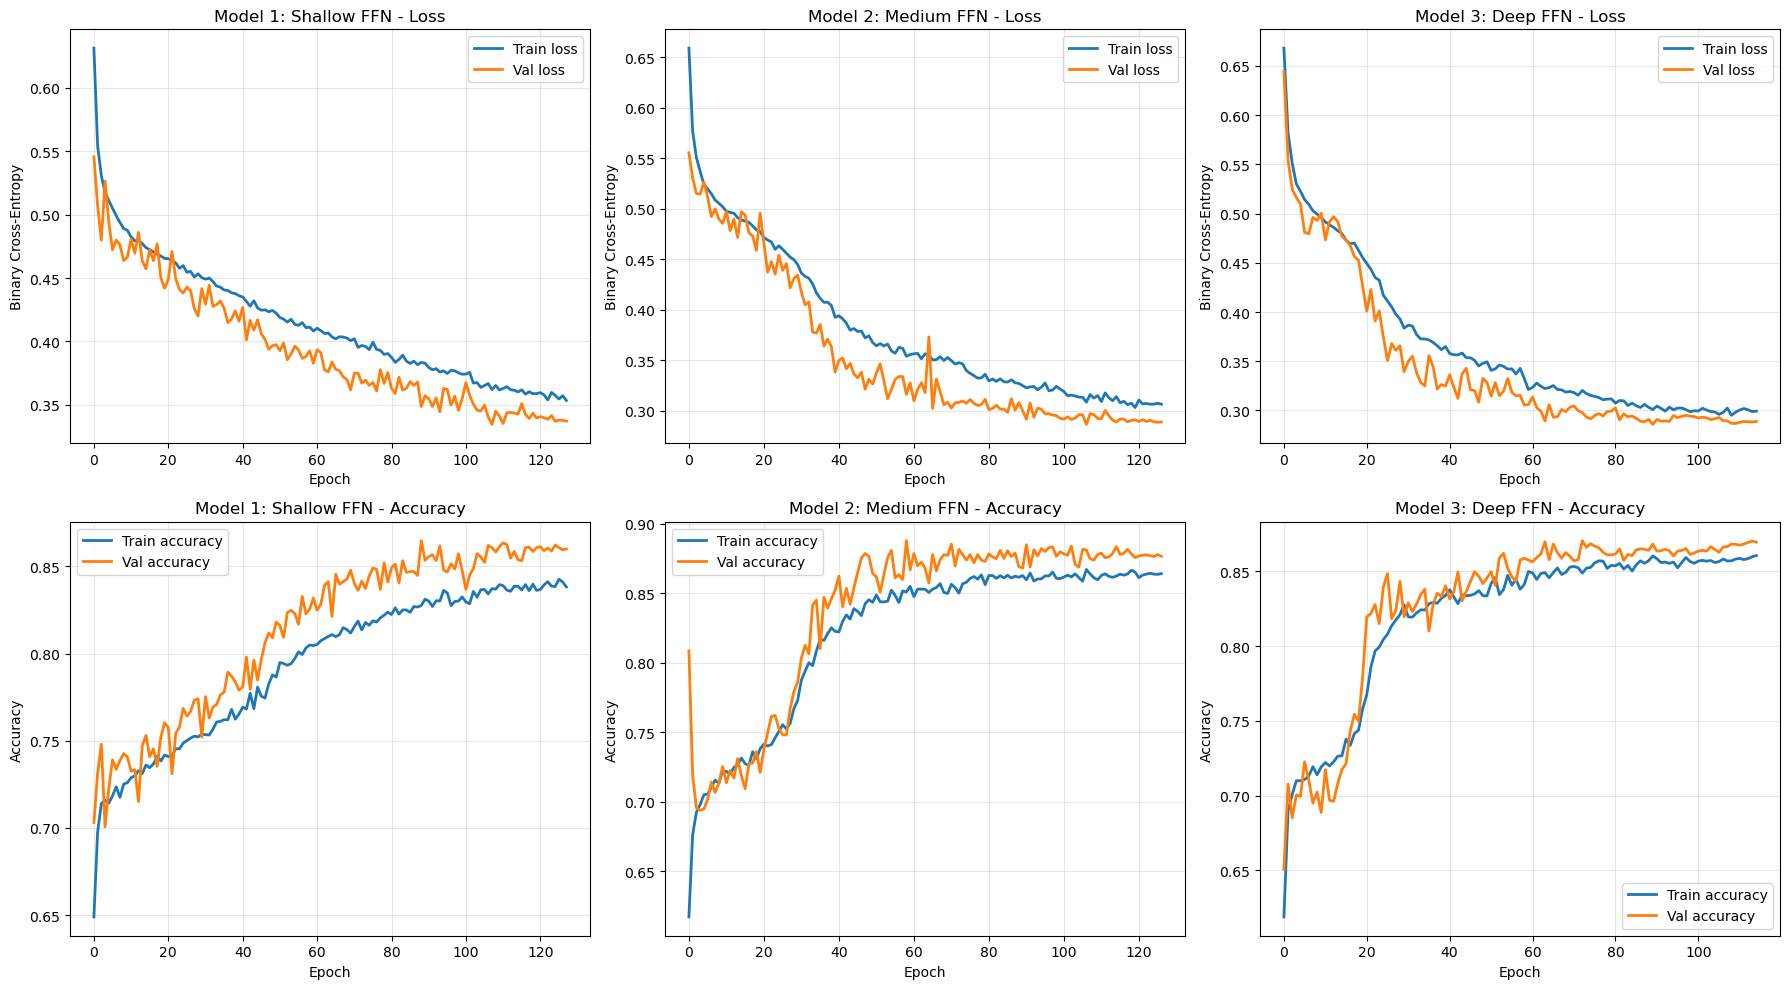

In [21]:
# Plot training curves for all 3 models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Model 1 plots
axes[0, 0].plot(history1.history['loss'], label='Train loss', linewidth=2)
axes[0, 0].plot(history1.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Cross-Entropy')
axes[0, 0].set_title('Model 1: Shallow FFN - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history1.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 0].plot(history1.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Model 1: Shallow FFN - Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Model 2 plots
axes[0, 1].plot(history2.history['loss'], label='Train loss', linewidth=2)
axes[0, 1].plot(history2.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Binary Cross-Entropy')
axes[0, 1].set_title('Model 2: Medium FFN - Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history2.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 1].plot(history2.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Model 2: Medium FFN - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Model 3 plots
axes[0, 2].plot(history3.history['loss'], label='Train loss', linewidth=2)
axes[0, 2].plot(history3.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Binary Cross-Entropy')
axes[0, 2].set_title('Model 3: Deep FFN - Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history3.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 2].plot(history3.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Model 3: Deep FFN - Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Model Evaluation & Comparison on Test Set


## 4. Model Comparison - Training Curves


In [ ]:
# Plot training curves for all 3 models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Model 1 plots
axes[0, 0].plot(history1.history['loss'], label='Train loss', linewidth=2)
axes[0, 0].plot(history1.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Cross-Entropy')
axes[0, 0].set_title('Model 1: Shallow FFN - Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history1.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 0].plot(history1.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Model 1: Shallow FFN - Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Model 2 plots
axes[0, 1].plot(history2.history['loss'], label='Train loss', linewidth=2)
axes[0, 1].plot(history2.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Binary Cross-Entropy')
axes[0, 1].set_title('Model 2: Medium FFN - Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history2.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 1].plot(history2.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Model 2: Medium FFN - Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Model 3 plots
axes[0, 2].plot(history3.history['loss'], label='Train loss', linewidth=2)
axes[0, 2].plot(history3.history['val_loss'], label='Val loss', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Binary Cross-Entropy')
axes[0, 2].set_title('Model 3: Deep FFN - Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history3.history['accuracy'], label='Train accuracy', linewidth=2)
axes[1, 2].plot(history3.history['val_accuracy'], label='Val accuracy', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Model 3: Deep FFN - Accuracy')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# Evaluate all 3 models on test set
print("="*80)
print("TEST SET EVALUATION - ALL 3 MODELS")
print("="*80)

results = {}

for i, (model, name) in enumerate([(model1, "Model 1: Shallow FFN"), 
                                    (model2, "Model 2: Medium FFN"), 
                                    (model3, "Model 3: Deep FFN")], 1):
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Get predictions
    probs = model.predict(X_test_np, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, preds, digits=3, target_names=['Non-pop', 'Pop']))
    
    # ROC AUC
    try:
        auc = roc_auc_score(y_test, probs)
        print(f"\nROC AUC: {auc:.4f}")
    except Exception as e:
        print(f"\nROC AUC: Could not compute - {e}")
        auc = 0.0
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'probs': probs,
        'preds': preds,
        'cm': cm
    }
    
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Non-pop  Pop")
    print(f"Actual Non-pop  {cm[0,0]:5d}  {cm[0,1]:4d}")
    print(f"        Pop     {cm[1,0]:5d}  {cm[1,1]:4d}")

# Summary comparison
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC AUC':<10}")
print("-"*80)
for name, metrics in results.items():
    print(f"{name:<25} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
          f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['auc']:<10.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")
print(f"   F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   ROC AUC: {results[best_model_name]['auc']:.4f}")


TEST SET EVALUATION - ALL 3 MODELS

Model 1: Shallow FFN

Classification Report:
              precision    recall  f1-score   support

     Non-pop      0.954     0.864     0.907      1677
         Pop      0.524     0.782     0.627       321

    accuracy                          0.851      1998
   macro avg      0.739     0.823     0.767      1998
weighted avg      0.885     0.851     0.862      1998


ROC AUC: 0.9232

Confusion Matrix:
                Predicted
              Non-pop  Pop
Actual Non-pop   1449   228
        Pop        70   251

Model 2: Medium FFN

Classification Report:
              precision    recall  f1-score   support

     Non-pop      0.959     0.892     0.924      1677
         Pop      0.587     0.801     0.677       321

    accuracy                          0.877      1998
   macro avg      0.773     0.846     0.801      1998
weighted avg      0.899     0.877     0.885      1998


ROC AUC: 0.9458

Confusion Matrix:
                Predicted
             

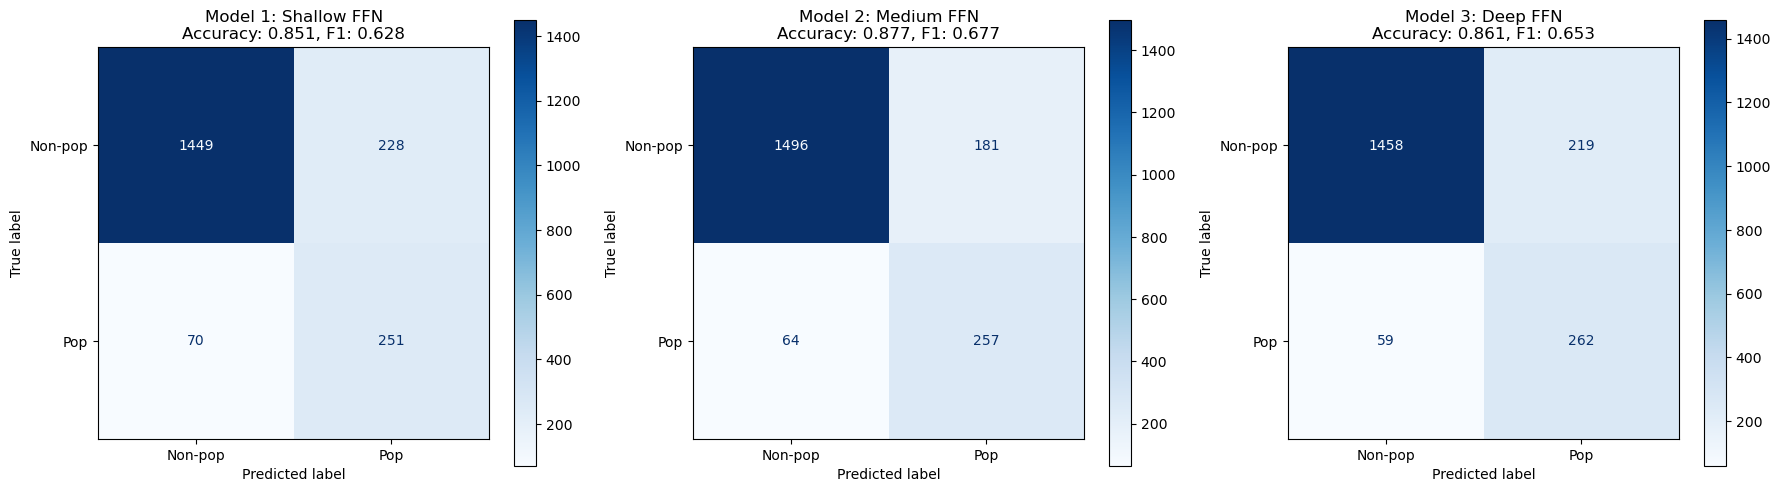

In [23]:
# Plot Confusion Matrices for all 3 models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, metrics) in enumerate(results.items()):
    cm = metrics['cm']
    disp = ConfusionMatrixDisplay(cm, display_labels=['Non-pop', 'Pop'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}\nAccuracy: {metrics["accuracy"]:.3f}, F1: {metrics["f1"]:.3f}')

plt.tight_layout()
plt.show()


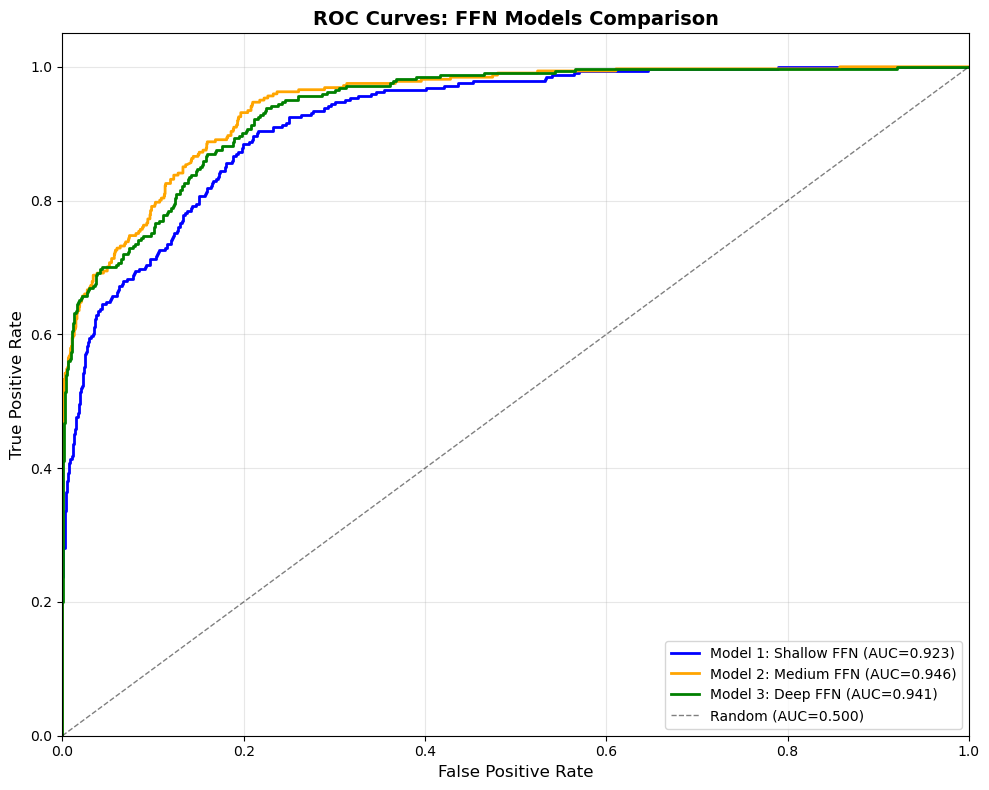

In [24]:
# Plot ROC Curves for all 3 models
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

colors = ['blue', 'orange', 'green']
for idx, (name, metrics) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, metrics['probs'])
    plt.plot(fpr, tpr, label=f'{name} (AUC={metrics["auc"]:.3f})', 
             linewidth=2, color=colors[idx])

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: FFN Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()


## 3. Improved Models


### Improved Keras FFNN


Class weights: {0: 0.5955926146515783, 1: 3.115264797507788}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,953 (23.25 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4845 - loss: 0.8585 - val_accuracy: 0.8191 - val_loss: 0.6838 - learning_rate: 0.0010
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6204 - loss: 0.7228 - val_accuracy: 0.8033 - val_loss: 0.6083 - learning_rate: 0.0010
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.6687 - loss: 0.6722 - val_accuracy: 0.7874 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.6882 - loss: 0.6432 - val_accuracy: 0.7796 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7047 - loss: 0.6243 - val_accuracy: 0.7579 - val_loss: 0.5381 - learning_rate: 0.0010
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6993 - loss: 0.6123 - val_accuracy: 0.7481 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.709

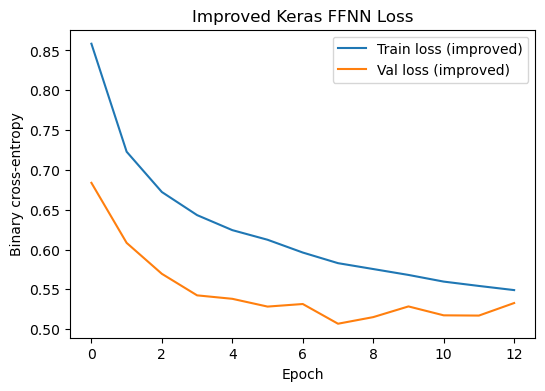

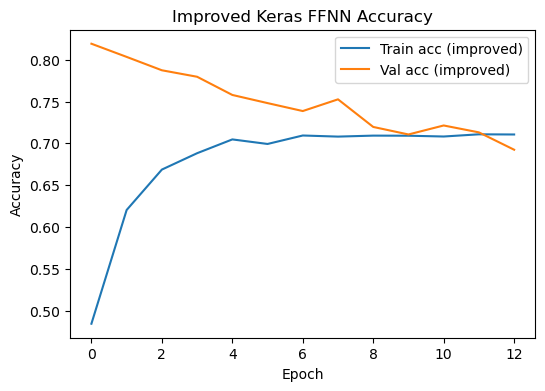

In [25]:
# Compute class weights for imbalanced labels
from sklearn.utils import class_weight

classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}
print('Class weights:', class_weight_dict)

# Build improved FFNN with BatchNorm, Dropout, and L2 regularization
reg = tfk.regularizers.l2(1e-3)  # Stronger L2 regularization to prevent overfitting
input_dim = X_train_np.shape[1]

improved_model = tfk.Sequential([
    tfl.Input(shape=(input_dim,)),
    tfl.Dense(64, activation='relu', kernel_regularizer=reg),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),  # Increased dropout to prevent overfitting
    tfl.Dense(32, activation='relu', kernel_regularizer=reg),
    tfl.BatchNormalization(),
    tfl.Dropout(0.5),  # Increased dropout to prevent overfitting
    tfl.Dense(16, activation='relu', kernel_regularizer=reg),
    tfl.Dense(1, activation='sigmoid'),
])

improved_model.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=[tfk.metrics.BinaryAccuracy(name='accuracy')]
)

improved_model.summary()

callbacks_improved = [
    tfkc.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # More aggressive early stopping
    tfkc.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
]

history_improved = improved_model.fit(
    X_train_np, y_train,
    validation_data=(X_val_np, y_val),
    epochs=100,
    batch_size=256,
    verbose=1,
    callbacks=callbacks_improved,
    class_weight=class_weight_dict,
)

# Plot loss and accuracy for the improved model
plt.figure(figsize=(6,4))
plt.plot(history_improved.history['loss'], label='Train loss (improved)')
plt.plot(history_improved.history['val_loss'], label='Val loss (improved)')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy')
plt.title('Improved Keras FFNN Loss')
plt.legend()
plt.show()

if 'accuracy' in history_improved.history:
    plt.figure(figsize=(6,4))
    plt.plot(history_improved.history['accuracy'], label='Train acc (improved)')
    plt.plot(history_improved.history.get('val_accuracy', []), label='Val acc (improved)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Improved Keras FFNN Accuracy')
    plt.legend()
    plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
Best threshold (by F1 for pop class): 0.60
Precision: 0.569, Recall: 0.452, F1: 0.503


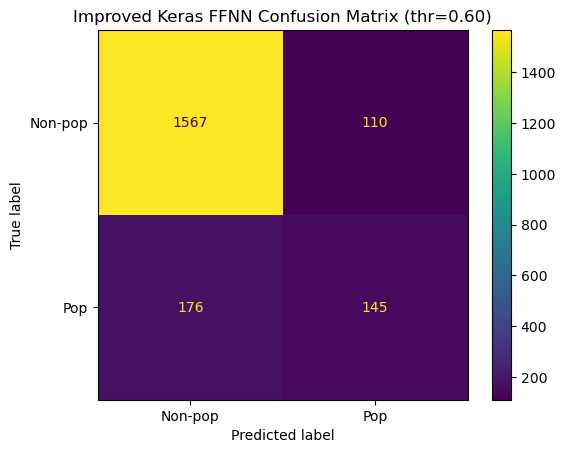

In [26]:
# Threshold tuning for improved model (optimize F1 for pop class)
from sklearn.metrics import precision_recall_fscore_support

probs_imp = improved_model.predict(X_test_np).ravel()

best_thresh = 0.5
best_f1 = -1.0
best_stats = None
thresholds = np.linspace(0.1, 0.9, 17)

for thr in thresholds:
    preds_thr = (probs_imp >= thr).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds_thr, average='binary', zero_division=0
    )
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thr
        best_stats = (precision, recall, f1)

print(f'Best threshold (by F1 for pop class): {best_thresh:.2f}')
print(f'Precision: {best_stats[0]:.3f}, Recall: {best_stats[1]:.3f}, F1: {best_stats[2]:.3f}')

# Confusion matrix at best threshold
best_preds = (probs_imp >= best_thresh).astype(int)
cm_imp = confusion_matrix(y_test, best_preds)
ConfusionMatrixDisplay(cm_imp, display_labels=['Non-pop', 'Pop']).plot()
plt.title(f'Improved Keras FFNN Confusion Matrix (thr={best_thresh:.2f})')
plt.show()
